In [1]:
# IMPORT NECESSARY LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import ast 

In [2]:
# LOADING AND COMBINING THE CORRECT DATASETS

print("\n--- Loading Datasets ---")
try:
    # Loading each dataset using the exact filenames you provided
    df_usa = pd.read_csv('linkedin-jobs-usa.csv')
    df_can = pd.read_csv('linkedin-jobs-canada.csv')
    df_afr = pd.read_csv('linkedin-jobs-africa.csv')

    # Add a 'country' column to each dataframe before combining
    df_usa['country'] = 'USA'
    df_can['country'] = 'Canada'
    df_afr['country'] = 'Africa'

    # Combine the three dataframes into a single master dataframe
    df = pd.concat([df_usa, df_can, df_afr], ignore_index=True)
    
    print("All datasets loaded and combined successfully!")
    print(f"Total combined job listings: {len(df)}")
    print("Initial data columns:", df.columns.tolist())

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all three CSV files are in the same directory as your script.")



--- Loading Datasets ---
All datasets loaded and combined successfully!
Total combined job listings: 8490
Initial data columns: ['title', 'company', 'description', 'onsite_remote', 'salary', 'location', 'criteria', 'posted_date', 'link', 'country']


In [3]:
# DATA CLEANING AND FEATURE ENGINEERING 

# 1. Parsing the 'criteria' column.
# This column is a string that looks like a list of dictionaries.
def parse_criteria(criteria_str):
    """Safely parses the string in the 'criteria' column into a usable dictionary."""
    try:
        # ast.literal_eval is safer than eval() for parsing Python literals
        criteria_list = ast.literal_eval(criteria_str)
        # Combine the list of dictionaries into a single dictionary
        criteria_dict = {k: v for d in criteria_list for k, v in d.items()}
        return criteria_dict
    except (ValueError, SyntaxError, TypeError):
        # Return an empty dictionary if the string is malformed or not a string
        return {}

# Apply the function to the 'criteria' column
criteria_parsed = df['criteria'].apply(parse_criteria)

# Convert the series of dictionaries into a new DataFrame
criteria_df = pd.json_normalize(criteria_parsed)

# Rename the new columns for better readability
criteria_df = criteria_df.rename(columns={
    'Seniority level': 'seniority_level',
    'Employment type': 'employment_type',
    'Job function': 'job_function',
    'Industries': 'industries'
})

# Join the new criteria columns back to the main DataFrame
df = pd.concat([df, criteria_df], axis=1)
print("1. 'criteria' column parsed and expanded.")


1. 'criteria' column parsed and expanded.


In [4]:
# 2. Cleaning the 'salary' column.
def extract_avg_salary(salary_str):
    """Extracts a numerical average salary from a string."""
    if pd.isna(salary_str):
        return None
    # Use regex to find all numbers, handling commas
    numbers = re.findall(r'\d{1,3}(?:,\d{3})*(?:\.\d+)?', str(salary_str))
    # Convert found numbers to float
    numbers = [float(n.replace(',', '')) for n in numbers]
    if numbers:
        # Return the average of the numbers found (handles salary ranges)
        return np.mean(numbers)
    return None

df['average_salary'] = df['salary'].apply(extract_avg_salary)
print("2. 'salary' column cleaned and 'average_salary' created.")


2. 'salary' column cleaned and 'average_salary' created.


In [5]:
# 3. Cleaning the 'onsite_remote' column.
df['work_model'] = df['onsite_remote'].str.capitalize()
print("3. 'onsite_remote' column standardized into 'work_model'.")


3. 'onsite_remote' column standardized into 'work_model'.


In [6]:
# 4. Extracting Key Skills from 'description'.
skills_to_track = ['sql', 'python', 'r', 'excel', 'tableau', 'power bi', 'aws', 'azure', 'gcp', 'spark', 'sas']
for skill in skills_to_track:
    df[f'mentions_{skill}'] = df['description'].str.contains(r'\b' + skill + r'\b', case=False, na=False)
print("4. Key skills extracted from 'description' column.")


4. Key skills extracted from 'description' column.


In [7]:
# 5. Finalizing the Cleaned DataFrame
# Drop original and now redundant columns
df_cleaned = df.drop(columns=['criteria', 'salary', 'onsite_remote', 'description', 'link', 'posted_date'], errors='ignore')

# Fill missing values in new categorical columns with 'Not Specified'
categorical_cols = ['seniority_level', 'employment_type', 'job_function', 'industries', 'work_model']
for col in categorical_cols:
    if col in df_cleaned.columns:
        df_cleaned[col].fillna('Not Specified', inplace=True)

print("\n--- Cleaning Complete ---")
print("Cleaned DataFrame Info:")
df_cleaned.info()

# Export the final cleaned data to a new CSV for use in Power BI
df_cleaned.to_csv('cleaned_global_linkedin_jobs.csv', index=False)
print("\nFinal cleaned data exported to 'cleaned_global_linkedin_jobs.csv'")


--- Cleaning Complete ---
Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8490 entries, 0 to 8489
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              8490 non-null   object 
 1   company            8490 non-null   object 
 2   location           8490 non-null   object 
 3   country            8490 non-null   object 
 4   seniority_level    8490 non-null   object 
 5   employment_type    8490 non-null   object 
 6   job_function       8490 non-null   object 
 7   industries         8490 non-null   object 
 8   مستوى الأقدمية     287 non-null    object 
 9   نوع التوظيف        360 non-null    object 
 10  المهام الوظيفية    287 non-null    object 
 11  المجالات           287 non-null    object 
 12  average_salary     965 non-null    float64
 13  work_model         8490 non-null   object 
 14  mentions_sql       8490 non-null   bool   
 15  mentions_python    84

C:\Users\laksh\AppData\Local\Temp\ipykernel_12524\341292925.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna('Not Specified', inplace=True)


In [8]:
# EXPLORATORY DATA ANALYSIS(EDA) AND VISUALIZATION

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)


C:\Users\laksh\AppData\Local\Temp\ipykernel_12524\863076154.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned, x='country', palette='Blues_r', order=df_cleaned['country'].value_counts().index)


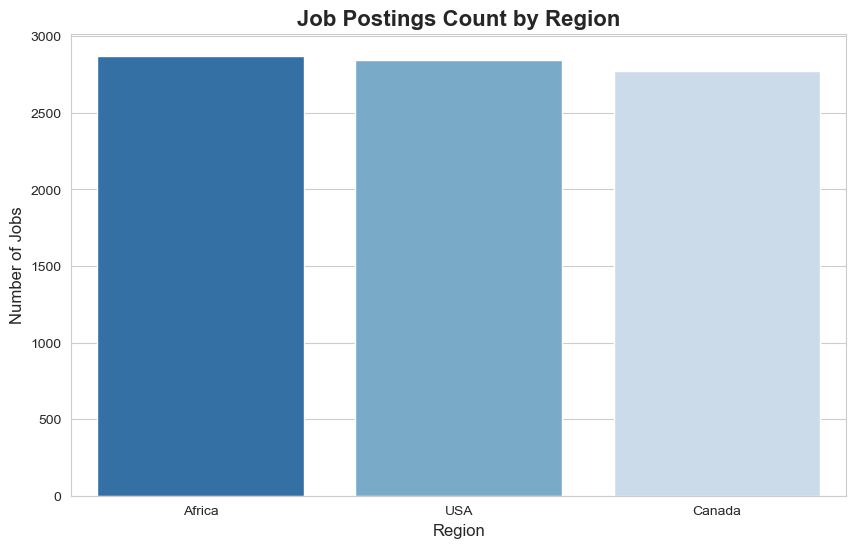

In [9]:
# Visualization 1: Job Postings Count by Region
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='country', palette='Blues_r', order=df_cleaned['country'].value_counts().index)
plt.title('Job Postings Count by Region', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.show()

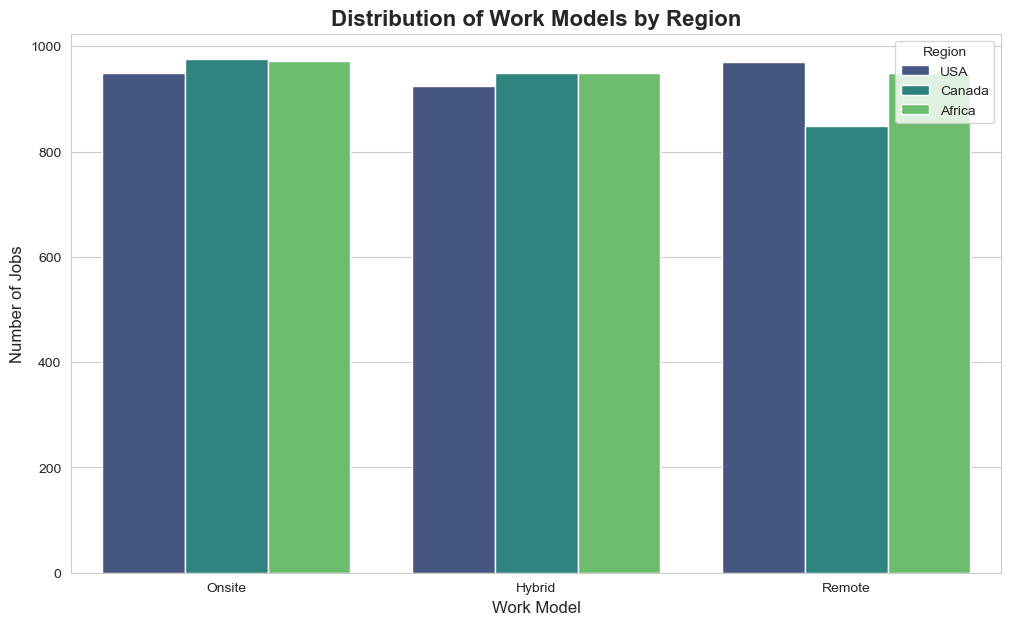

In [10]:
# Visualization 2: Distribution of Work Models by Region
plt.figure(figsize=(12, 7))
sns.countplot(data=df_cleaned, x='work_model', hue='country', palette='viridis', order=df_cleaned['work_model'].value_counts().index)
plt.title('Distribution of Work Models by Region', fontsize=16, fontweight='bold')
plt.xlabel('Work Model', fontsize=12)
plt.ylabel('Number of Jobs', fontsize=12)
plt.legend(title='Region')
plt.show()

C:\Users\laksh\AppData\Local\Temp\ipykernel_12524\2758062128.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=usa_salary_data_filtered, x='average_salary', y='seniority_level', palette='coolwarm',


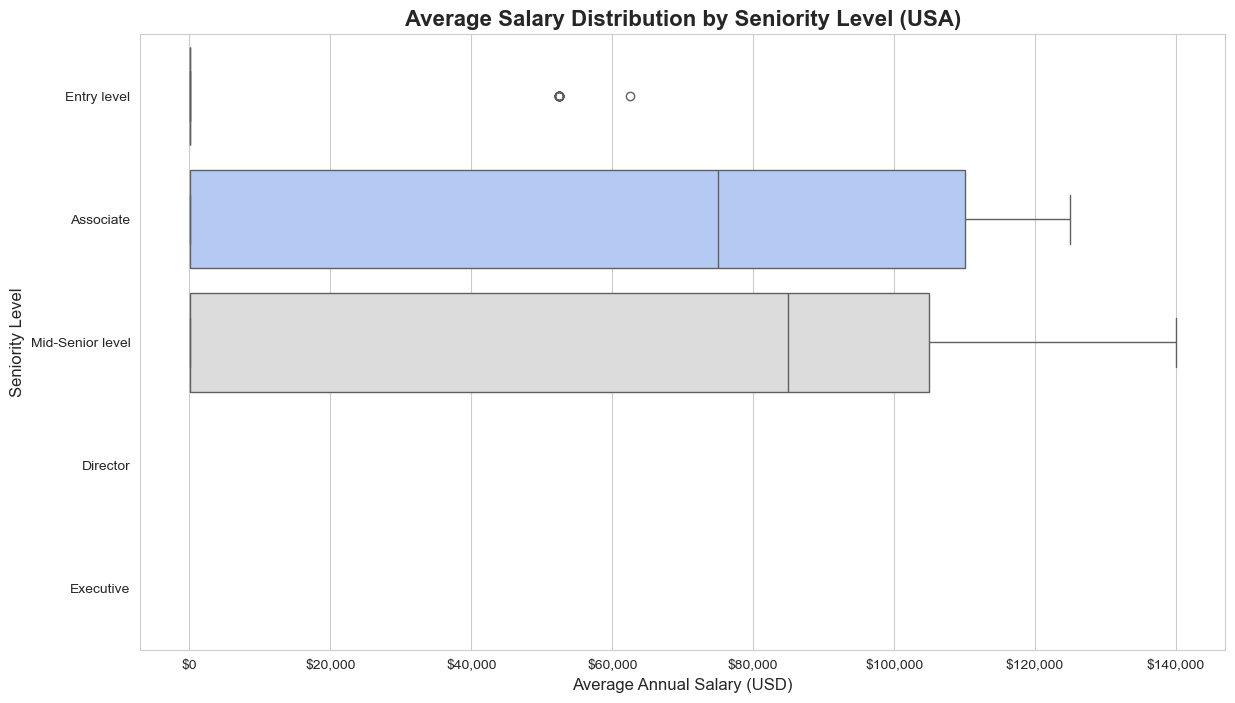

In [11]:
# Visualization 3: Salary Distribution by Seniority Level (USA Data)
# Filter for USA data where salary exists and remove extreme outliers for a better plot.
usa_salary_data = df_cleaned[(df_cleaned['country'] == 'USA') & (df_cleaned['average_salary'].notna())]
q99 = usa_salary_data['average_salary'].quantile(0.99)
usa_salary_data_filtered = usa_salary_data[usa_salary_data['average_salary'] <= q99]

plt.figure(figsize=(14, 8))
sns.boxplot(data=usa_salary_data_filtered, x='average_salary', y='seniority_level', palette='coolwarm',
            order=['Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive'])
plt.title('Average Salary Distribution by Seniority Level (USA)', fontsize=16, fontweight='bold')
plt.xlabel('Average Annual Salary (USD)', fontsize=12)
plt.ylabel('Seniority Level', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.show()

C:\Users\laksh\AppData\Local\Temp\ipykernel_12524\4181343053.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_industries.index, x=top_industries.values, palette='magma')


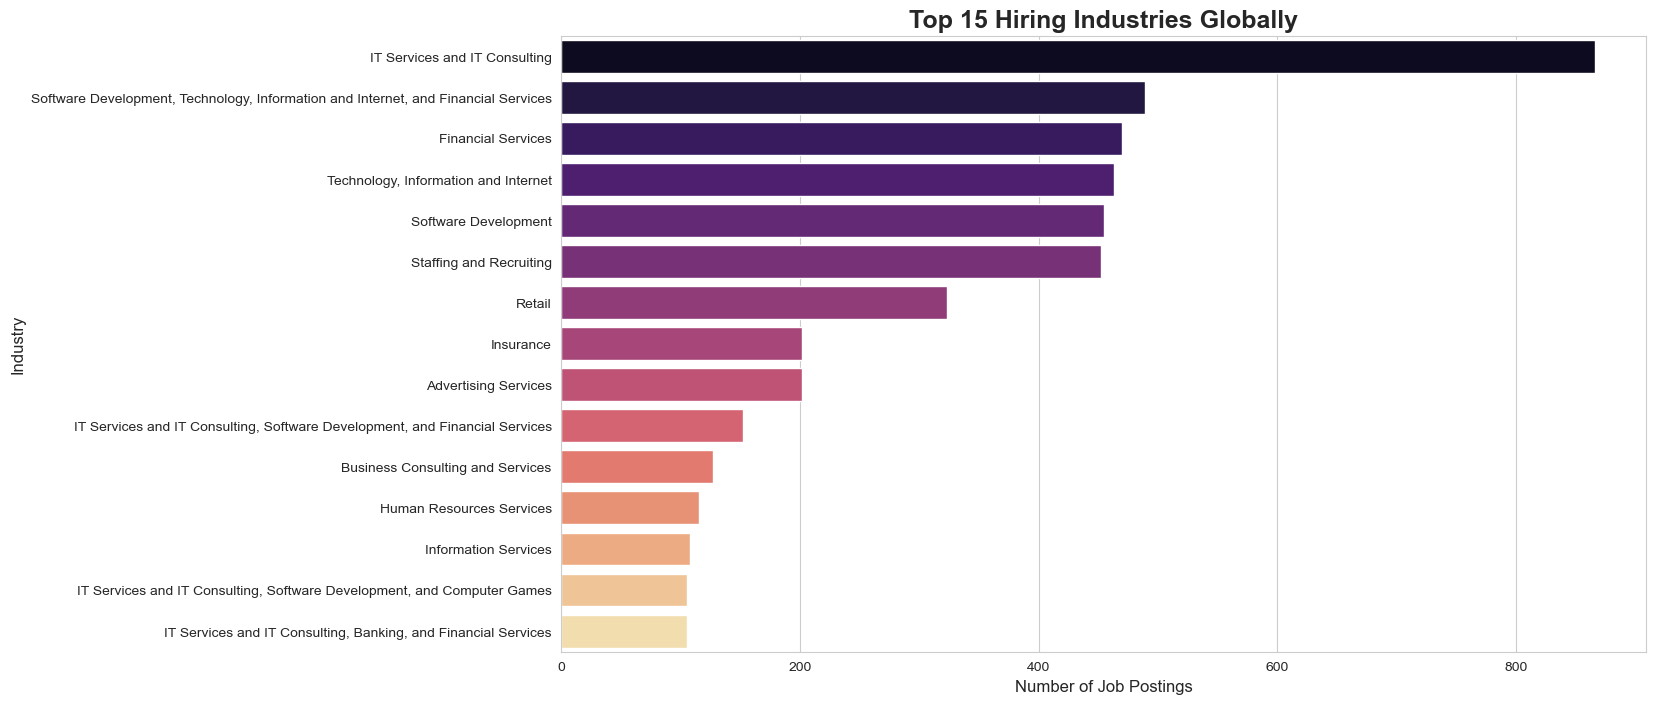

In [12]:
# Visualization 4: Top 15 Hiring Industries Globally
top_industries = df_cleaned[df_cleaned['industries'] != 'Not Specified']['industries'].value_counts().nlargest(15)
plt.figure(figsize=(14, 8))
sns.barplot(y=top_industries.index, x=top_industries.values, palette='magma')
plt.title('Top 15 Hiring Industries Globally', fontsize=18, fontweight='bold')
plt.xlabel('Number of Job Postings', fontsize=12)
plt.ylabel('Industry', fontsize=12)
plt.show()

C:\Users\laksh\AppData\Local\Temp\ipykernel_12524\781308038.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skill_counts.index, y=skill_counts.values, palette='viridis')


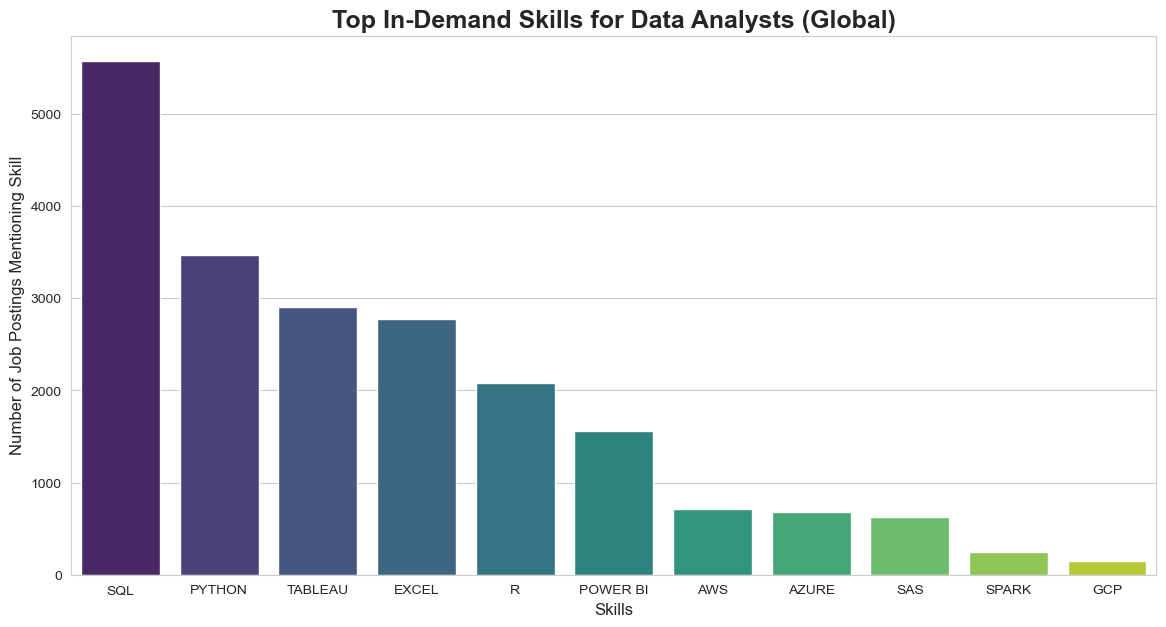

In [13]:
# Visualization 5: Most In-Demand Skills Globally
skill_columns = [f'mentions_{skill}' for skill in skills_to_track]
skill_counts = df_cleaned[skill_columns].sum().sort_values(ascending=False)
skill_counts.index = [s.replace('mentions_', '').upper() for s in skill_counts.index] # Clean up labels
plt.figure(figsize=(14, 7))
sns.barplot(x=skill_counts.index, y=skill_counts.values, palette='viridis')
plt.title('Top In-Demand Skills for Data Analysts (Global)', fontsize=18, fontweight='bold')
plt.xlabel('Skills', fontsize=12)
plt.ylabel('Number of Job Postings Mentioning Skill', fontsize=12)
plt.show()



In [14]:
print("\n--- Analysis and Visualization Complete ---")


--- Analysis and Visualization Complete ---
